<a href="https://colab.research.google.com/github/navneetkrc/Colab_fastai/blob/master/Intel_Image_Classification3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Need v1.0.25 of fastai which is not yet published so install it from GitHub.

In [1]:
# To determine which version you're using:
!pip show tensorflow

# For the current version: 
!pip install --upgrade tensorflow

# For a specific version:
#!pip install tensorflow==1.2

# For the latest nightly build:
#!pip install tf-nightly


Name: tensorflow
Version: 1.12.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: opensource@google.com
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: keras-applications, absl-py, wheel, protobuf, six, astor, gast, numpy, grpcio, tensorboard, termcolor, keras-preprocessing
Required-by: stable-baselines, magenta, fancyimpute
Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (1.12.0)


In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

In [3]:
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html

Looking in links: https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
    100% |████████████████████████████████| 576.2MB 26kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x622de000 @  0x7f7fab7eb2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [4]:
import torch
print(torch.__version__)
!pip install torchtext==0.2.3
!pip install Pillow==4.0.0
!pip install PIL
!pip install image

1.0.0.dev20181206
    100% |████████████████████████████████| 51kB 2.5MB/s 
  Running setup.py bdist_wheel for torchtext ... - done
  Stored in directory: /root/.cache/pip/wheels/42/a6/f4/b267328bde6bb680094a0c173e8e5627ccc99543abded97204
Successfully built torchtext
  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL


We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [5]:
!pip install fastai

    100% |████████████████████████████████| 153kB 8.4MB/s 
    100% |████████████████████████████████| 591.8MB 26kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x60fa6000 @  0x7fb116ffb2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 112kB 32.6MB/s 
    100% |████████████████████████████████| 61kB 25.1MB/s 
  Running setup.py bdist_wheel for nvidia-ml-py3 ... - done
  Stored in directory: /root/.cache/pip/wheels/e4/1d/06/640c93f5270d67d0247f30be91f232700d19023f9e66d735c7
  Running setup.py bdist_wheel for bottleneck ... - \ | / - \ | / done
  Stored in directory: /root/.cache/pip/wheels/f2/bf/ec/e0f39aa27001525ad455139ee57ec7d0776fe074dfd78c97e4
Successfully built nvidia-ml-py3 bottleneck
torchvision 0.

In [0]:
from fastai import *
from fastai.vision import *
import pandas as pd 

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [0]:
bs = 64
#bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

#  Intel Scene Classification Image Dataset

## Looking at the data

###Getting Dataset from Kaggle

In [8]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"navneetkrch","key":"4910f3543e9486158ccfa00ca84b274f"}'> ~/.kaggle/kaggle.json  # Replace
!chmod 600 kaggle.json


chmod: cannot access 'kaggle.json': No such file or directory


In [9]:
!mkdir -p data
!kaggle datasets download -d nitishabharathi/scene-classification

 96% 343M/358M [00:03<00:00, 123MB/s]
100% 358M/358M [00:03<00:00, 97.9MB/s]


In [10]:
!unzip scene-classification.zip 

Archive:  scene-classification.zip
  inflating: test_WyRytb0.csv        
  inflating: train-scene classification.zip  


In [11]:
!unzip train-scene\ classification.zip -d data/
!mv test_WyRytb0.csv data/test.csv
!mv data/train.csv data/train/labels.csv

Archive:  train-scene classification.zip
   creating: data/train/
  inflating: data/train.csv          
  inflating: data/train/0.jpg        
  inflating: data/train/1.jpg        
  inflating: data/train/10.jpg       
  inflating: data/train/100.jpg      
  inflating: data/train/1000.jpg     
  inflating: data/train/10000.jpg    
  inflating: data/train/10001.jpg    
  inflating: data/train/10002.jpg    
  inflating: data/train/10003.jpg    
  inflating: data/train/10004.jpg    
  inflating: data/train/10005.jpg    
  inflating: data/train/10006.jpg    
  inflating: data/train/10007.jpg    
  inflating: data/train/10008.jpg    
  inflating: data/train/10009.jpg    
  inflating: data/train/1001.jpg     
  inflating: data/train/10010.jpg    
  inflating: data/train/10011.jpg    
  inflating: data/train/10012.jpg    
  inflating: data/train/10013.jpg    
  inflating: data/train/10014.jpg    
  inflating: data/train/10015.jpg    
  inflating: data/train/10016.jpg    
  inflating: data/trai

In [12]:
print("all files unzipped. Images in train folder and labels in test.csv")

all files unzipped. Images in train folder and labels in test.csv


###Setting the path for data

We are going to use the [Intel Image Scene](https://www.kaggle.com/nitishabharathi/scene-classification) by [Analytics Vidhya](https://datahack.analyticsvidhya.com/contest/practice-problem-intel-scene-classification-challe/) which features 6 scenes.

Our model will need to learn to differentiate between these 6 distinct categories. 
We use **FASTAI-V1** model to get the results.

####DATASET DESCRIPTION
**There are 17034 images in train and 7301 images in test data.**

The categories of natural scenes and their corresponding labels in the dataset are as follows -

 ** 'buildings' -> 0,**

**'forest' -> 1,** 

**'glacier' -> 2,**

**'mountain' -> 3,**

**'sea' -> 4, **

**'street' -> 5 **

There are three files provided to you, viz **train.zip, test.csv and sample_submission.csv** which have the following structure.

Variable	Definition

image_name	Name of the image in the dataset (ID column)

label	Category of natural scene (target column)

**train.zip contains the images corresponding to both train and test set along with the true labels for train set images in train.csv**

In [13]:
path = 'data';path

'data'

In [0]:
path_img = 'data/train'

In [15]:
fnames = get_image_files(path_img)
fnames[:5]


[PosixPath('data/train/13750.jpg'),
 PosixPath('data/train/2167.jpg'),
 PosixPath('data/train/9995.jpg'),
 PosixPath('data/train/22738.jpg'),
 PosixPath('data/train/10257.jpg')]

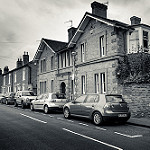

In [16]:
from IPython.display import Image 
Image(filename='data/train/13664.jpg')

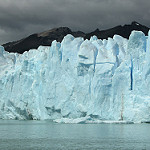

In [17]:
from IPython.display import Image 
Image(filename='data/train/11432.jpg')

In [18]:
os.listdir('data/')

['train', 'test.csv']

###Loading and Understanding the Data
The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data, means **understanding how the data directories are structured**, what the **labels** are and what some **sample images** look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, **6 labels** are stored based on the csv files.

Fortunately, the fastai library has a handy function made exactly for this.

[Image data from CSV / DataFrame](https://docs.fast.ai/vision.data.html#ImageDataBunch.from_csv).

##Loading Labels [From_CSV](https://github.com/fastai/fastai/blob/master/fastai/vision/data.py#L131)

from_csv[source]

from_csv(`path`:PathOrStr, `folder`:PathOrStr=`'.'`, `sep`=`None`, `csv_labels`:PathOrStr=`'labels.csv'`, `valid_pct`:float=`0.2`, `fn_col`:int=`0`, `label_col`:int=`1`, `suffix`:str=`''`, `header`:Union[int, str, NoneType]=`'infer'`, `kwargs`:Any) → ImageDataBunch

Create from a csv file in path/csv_labels.

**data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=24);**




**File Structure**

path\

    labels.csv -> label for training images
    test.csv -> list of test images without labels
    
    train\
      all images
      
 train.csv contains correct labels of **17034 images** in train 
 
 test.csv contains list of **7301 images** in train folder itself but without labels.


In [0]:
tfms = get_transforms()
data = ImageDataBunch.from_csv(path_img, ds_tfms=tfms, size=300)
#data = ImageDataBunch.from_csv(path, train='train','../labels.csv', valid_pct=0.2, ds_tfms=tfms, size=224,classes=[str(i) for i in range(6)])

In [20]:
label_df = pd.read_csv('data/train/labels.csv')
label_df.head()

,image_name,label
0,0.jpg,0
1,1.jpg,4
2,2.jpg,5
3,4.jpg,0
4,7.jpg,4


In [21]:
print(data.classes)
len(data.classes),data.c

[0, 1, 2, 3, 4, 5]


(6, 6)

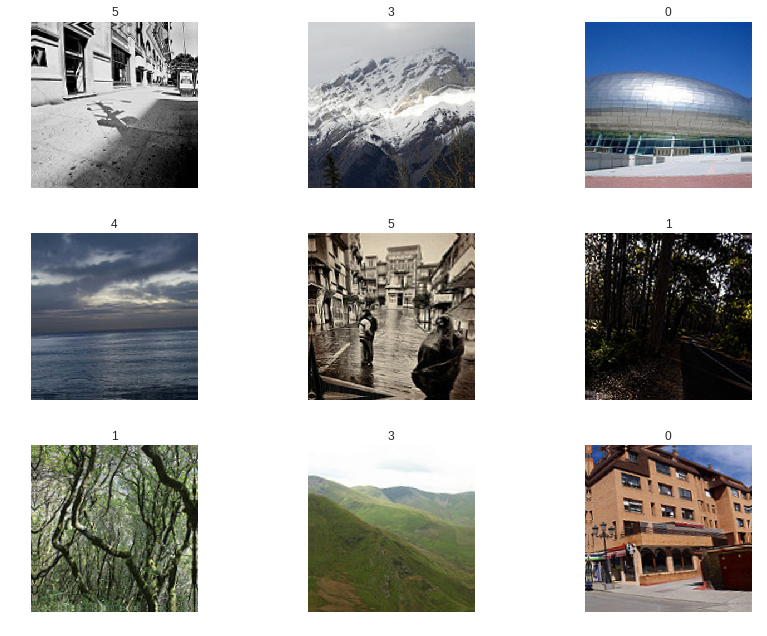

In [22]:
data.show_batch(rows=3, figsize=(12,9))

# Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [0]:
#For Metrics to have Top 3 results
from fastai import *
from sklearn import metrics as skm

In [24]:
learn = create_cnn(data, models.resnet50, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:04<00:00, 25477719.66it/s]


epoch,train_loss,valid_loss,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


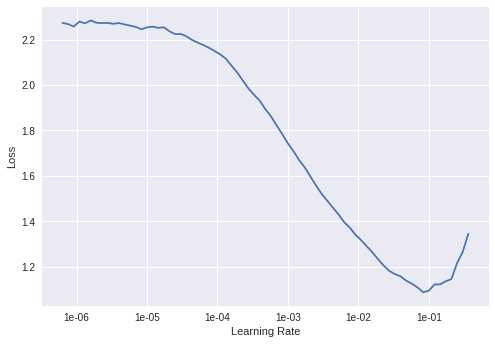

In [25]:
learn.lr_find()
learn.recorder.plot()

##Train and save the model checkpoint

In [26]:
learn.fit_one_cycle(5) ## best way to fit as of 2018
print("learning complete")

epoch,train_loss,valid_loss,accuracy
1,0.372785,0.246397,0.909278
2,0.277815,0.201908,0.923664
3,0.235973,0.187985,0.930417
4,0.181202,0.176362,0.937170
5,0.167624,0.172775,0.934527


learning complete


In [27]:
print("we save after 1st weights are learned")
learn.save('stage-1-550')
#learn.load('stage-1-550')

we save after 1st weights are learned


Let's see if full fine-tuning helps:

In [28]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,accuracy
1,0.177491,0.199685,0.926013
2,0.203728,0.204209,0.926307
3,0.147181,0.168823,0.938931
4,0.097257,0.164569,0.944216
5,0.062016,0.157090,0.945978


In [29]:
learn.save('stage-2-550')
#learn.load('stage-2-550')

print("we save after 2nd weights are learned")

we save after 2nd weights are learned


If it doesn't, you can always go back to your previous model.

In [30]:
print("weights loaded")

weights loaded


In [0]:
interp = ClassificationInterpretation.from_learner(learn)

**interp.plot_top_losses(9, figsize=(15,11)) # Prediction/ Actual/ Loss/ Probability**

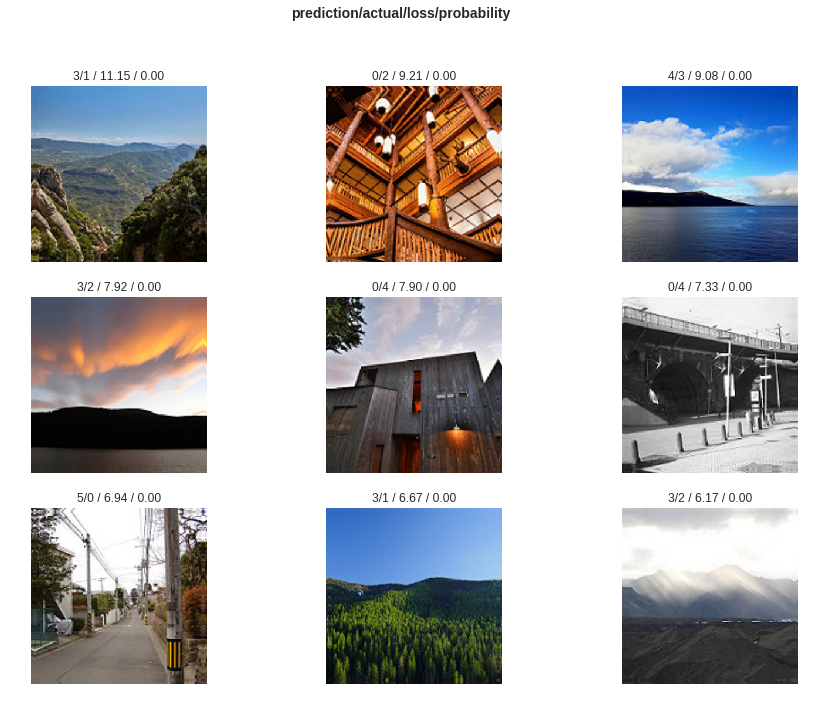

In [32]:
interp.plot_top_losses(9, figsize=(15,11)) # Prediction/ Actual/ Loss/ Probability

In [33]:
interp.most_confused()

[(3, 2, 54),
 (2, 3, 50),
 (0, 5, 23),
 (5, 0, 17),
 (3, 4, 7),
 (2, 4, 6),
 (4, 0, 5),
 (4, 3, 4),
 (2, 0, 3),
 (4, 2, 3),
 (1, 3, 2),
 (5, 2, 2),
 (5, 4, 2)]

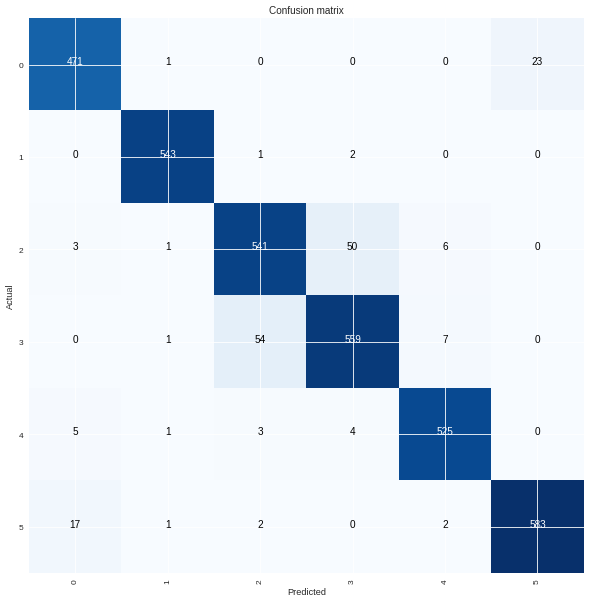

In [34]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)



---



###Start the Prediction for the Test Dataset based on test csv

In [0]:
#test_files = os.listdir('data/test')
#test_df = pd.read_csv(f'{path}test.csv')
#print("test files are") 
#test_files
#test_file_name = pd.DataFrame(test_files)
print(test_file_name.nunique())


In [0]:
#demo = []
  img = learn.data.test_ds[0][0]
  a = learn.predict(img)
  b = list(a)[2]
  print(a)
  c = pd.DataFrame([[i, b[i]] for i in range(len(b))])
  c.columns = ["class","probability"]
  #print(c)
  d = c.sort_values("probability", ascending = False)
  #demo.append(d[:3])
  #d = sorted(c, reverse = True)
  print(d[:3])

#??learn.predict

In [0]:
preds,_ = learn.get_preds(DatasetType.Test);

In [0]:
pred,y = learn.TTA(DatasetType.Test);

In [0]:
# Predict into the test set
learn.get_preds(DatasetType.Test)
test_output = learn.get_preds(is_test=True)
log_probs, y = test_output

In [0]:
DatasetType.Test[0]

In [0]:
test_ids = list(sorted({fname.split('_')[0] for fname in os.listdir(path/'test')}))

data.test_ds.x

test.
#pred_labels = [' '.join(list([str(i) for i in np.nonzero(row>0.2)[0]])) for row in np.array(preds)];pred_labels
#df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
#df.to_csv(path/'protein_predictions_datablocks.csv', header=True, index=False)

In [0]:
preds.info()


In [0]:
predsnp = np.array(preds)
predsdf = pd.DataFrame(predsnp)

In [0]:
predsdf

In [0]:
predsdf.to_csv("preds.csv")